In [7]:
!pip install keras_tuner
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential, Model, load_model
from keras.layers import Reshape, Dense, Input
from sklearn.model_selection import train_test_split
import keras_tuner as kt
#for visualising neural network
from keras.utils import plot_model

In [9]:
initalizer1 = keras.initializers.GlorotNormal
initalizer2 = keras.initializers.HeNormal

In [10]:
#Define the R2 metric function
def r2_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (SS_res / (SS_tot + tf.keras.backend.epsilon()))

In [11]:
import os
from natsort import natsorted

#Paths to data folders on Kaggle
stress_dir="/kaggle/input/deep-learning/Q7/stress_node"
vf_dir="/kaggle/input/deep-learning/Q7/volume fraction"

#Sorted file 
stress_files=natsorted(os.listdir(stress_dir))
vf_files=natsorted(os.listdir(vf_dir))

#Initialize arrays
X=np.zeros((10000,441))  #Inputs:441 volume fractions
y=np.zeros((10000,1))    #Output:max von Mises stress

#von Mises formula
def compute_von_mises(tau_xx, tau_yy, tau_xy):
    return np.sqrt(tau_xx**2 - tau_xx * tau_yy + tau_yy**2 + 3 * tau_xy**2)

#Load data
for i in range(10000):
    vf=np.loadtxt(os.path.join(vf_dir, vf_files[i]))
    stress=np.loadtxt(os.path.join(stress_dir, stress_files[i]))

    X[i,:]=vf.flatten()

    #Columns:node_id,τxx,τyy,τxy
    von_mises=compute_von_mises(stress[:,1], stress[:,2], stress[:,3])
    y[i]=np.max(von_mises)

In [13]:
#For input X
X_mean=np.mean(X,axis=0)
X_std=np.std(X,axis=0)
X_scaled=(X-X_mean)/X_std

#For target y
y_mean=np.mean(y)
y_std=np.std(y)
y_scaled=(y-y_mean)/y_std

#Split data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_scaled,test_size=0.15,random_state=42)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

initializer=initalizer2()  

model=Sequential()
model.add(Dense(256, activation='relu', kernel_initializer=initializer, input_shape=(441,)))
model.add(Dense(128, activation='relu', kernel_initializer=initializer))
model.add(Dense(64, activation='relu', kernel_initializer=initializer))
model.add(Dense(1, kernel_initializer=initializer))

model.compile(optimizer=Adam(learning_rate=0.001),loss='mse',metrics=[r2_metric])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-21 08:12:21.264828: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3008 - r2_metric: 0.7099 - val_loss: 0.0176 - val_r2_metric: 0.9779
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0154 - r2_metric: 0.9823 - val_loss: 0.0120 - val_r2_metric: 0.9853
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - r2_metric: 0.9909 - val_loss: 0.0102 - val_r2_metric: 0.9874
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0086 - r2_metric: 0.9908 - val_loss: 0.0119 - val_r2_metric: 0.9856
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0062 - r2_metric: 0.9934 - val_loss: 0.0100 - val_r2_metric: 0.9886
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0040 - r2_metric: 0.9956 - val_loss: 0.0047 - val_r2_metric: 0.9942
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - r2_metric: 0.9965 - val_loss: 0.0054 - val_r2_metric: 0.9932
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0043 - r2_metric: 0.

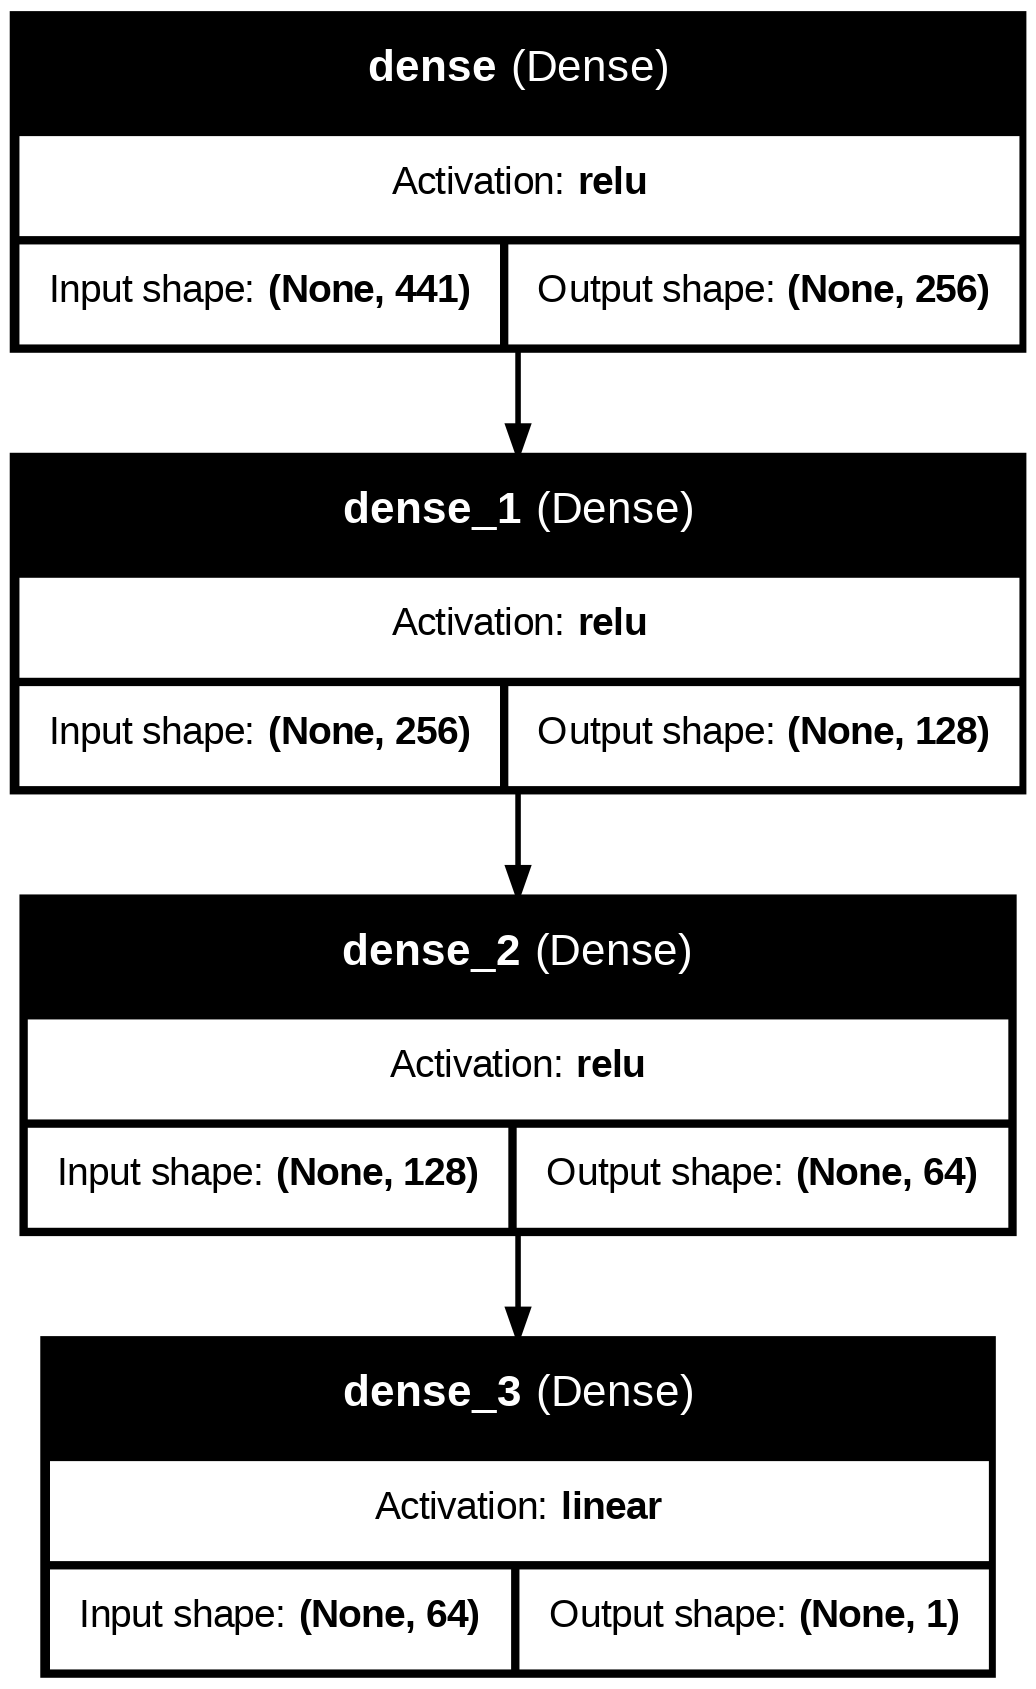

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [16]:
y_pred_scaled=model.predict(X_test)

#Inverse transform y_pred and y_test
y_pred=y_pred_scaled*y_std + y_mean
y_true=y_test*y_std+y_mean

from sklearn.metrics import mean_squared_error, r2_score
mse=mean_squared_error(y_true, y_pred)
r2=r2_score(y_true, y_pred)

test_loss,test_r2=model.evaluate(X_test, y_test)

print("Test Loss:",test_loss)
print("Test R2-score:",test_r2)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4522e-04 - r2_metric: 0.9994
Test Loss: 0.0005434873746708035
Test R2-score: 0.999413013458252


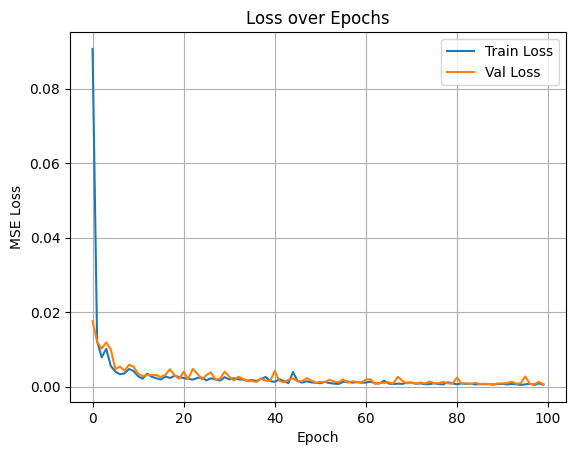

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.legend()
plt.show()


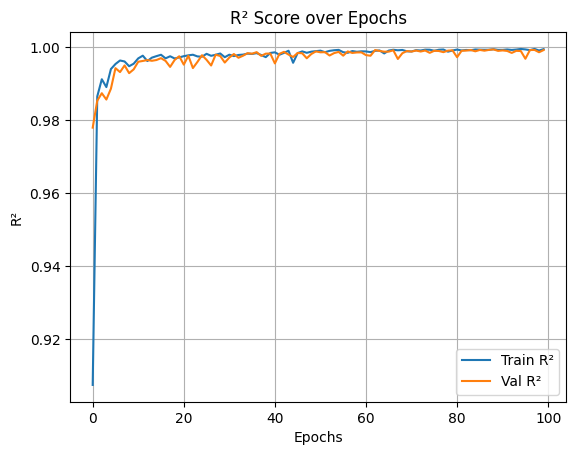

In [18]:
if 'r2_metric' in history.history:
    plt.plot(history.history['r2_metric'], label='Train R²')
    plt.plot(history.history['val_r2_metric'], label='Val R²')
    plt.title("R² Score over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("R²")
    plt.legend()
    plt.grid()
    plt.show()

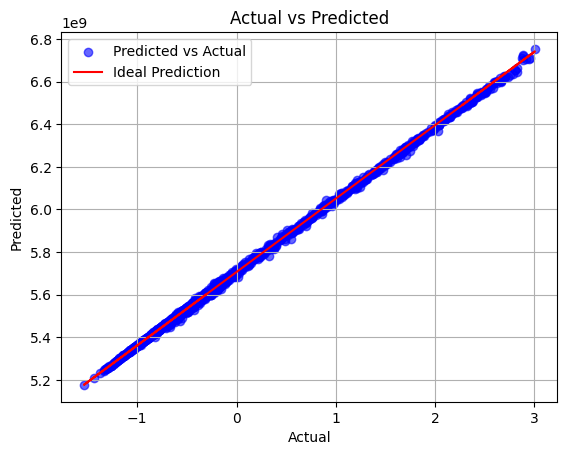

In [19]:
plt.scatter(y_test, y_pred, label='Predicted vs Actual', color='blue', alpha=0.6)
plt.plot(y_test, y_true, label='Ideal Prediction', color='red')  #y = x line

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

#For input X
X_mean=np.mean(X, axis=0)
X_std=np.std(X, axis=0)
X_scaled=(X-X_mean)/X_std

#For output y
y_mean=np.mean(y)
y_std=np.std(y)
y_scaled=(y-y_mean)/y_std

#PCA 
pca=PCA(n_components=50)
X_pca=pca.fit_transform(X_scaled)
print("Reduced shape:",X_pca.shape)  #Should be (10000,50)

#Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_scaled, test_size=0.15, random_state=42)

Reduced shape: (10000, 50)


In [21]:
initializer=initalizer2()  #initialiser

model_pca=Sequential([
    Dense(128,activation='relu', kernel_initializer=initializer,input_shape=(X_train.shape[1],)),
    Dense(64,activation='relu', kernel_initializer=initializer),
    Dense(1,kernel_initializer=initializer)
])

model_pca.compile(optimizer=Adam(learning_rate=0.001),loss='mse',metrics=[r2_metric])

#Train
history_pca=model_pca.fit(X_train, y_train, validation_split=0.2,epochs=100,batch_size=32,verbose=1)

#Evaluate
#Prediction
y_pred_scaled=model_pca.predict(X_test)

#reverse scaling
y_pred=y_pred_scaled*y_std+y_mean
y_true=y_test*y_std+y_mean

#Metrics in original space
from sklearn.metrics import mean_squared_error, r2_score
mse=mean_squared_error(y_true, y_pred)
r2=r2_score(y_true, y_pred)

test_loss, test_r2 = model_pca.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss (MSE): {test_loss:.4f}")
print(f"Test R² Score: {test_r2:.4f}")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1624 - r2_metric: -0.2462 - val_loss: 0.1206 - val_r2_metric: 0.8418
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0893 - r2_metric: 0.8953 - val_loss: 0.0618 - val_r2_metric: 0.9202
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0483 - r2_metric: 0.9449 - val_loss: 0.0447 - val_r2_metric: 0.9390
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0320 - r2_metric: 0.9639 - val_loss: 0.0330 - val_r2_metric: 0.9575
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0225 - r2_metric: 0.9741 - val_loss: 0.0297 - val_r2_metric: 0.9619
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0180 - r2_metric: 0.9796 - val_loss: 0.0228 - val_r2_metric: 0.9715
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0138 - r2_metric: 0.9826 - val_loss: 0.0197 - val_r2_metric: 0.9758
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0120 - r2_metric: 0.9863 - val_

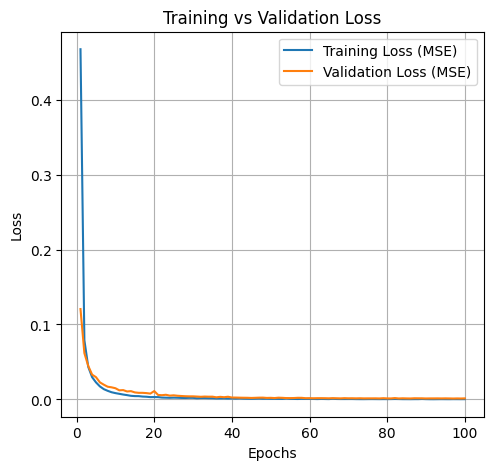

In [22]:
#Extract history
loss=history_pca.history['loss']
val_loss=history_pca.history['val_loss']
r2=history_pca.history['r2_metric']
val_r2=history_pca.history['val_r2_metric']
epochs=range(1, len(loss) + 1)

#Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss (MSE)')
plt.plot(epochs, val_loss, label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.show()


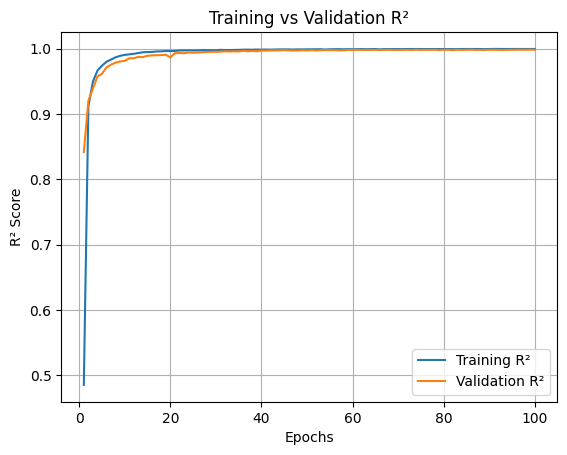

In [23]:
plt.plot(epochs, r2, label='Training R²')
plt.plot(epochs, val_r2, label='Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.title('Training vs Validation R²')
plt.legend()
plt.grid(True)